#📌**Sommaire du Notebook : Analyse Prédictive de Solvabilité Bancaire :**
# * Chargement et visualisation des données.

# * Prétraitement des données.

# * Analyse exploratoire (EDA).

# * Modélisation (Régression Logistique, KNN).

# * Évaluation des performances des modèles avec k-fold Cross Validation .







In [ ]:
# Installer pyreadstat si besoin
!pip install pyreadstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 81.5 MB/s eta 0:00:00


# 📊 Préparation des Données:

In [ ]:
import pyreadstat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve ,accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, classification_report,
                           accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score, roc_curve, auc,
                             PrecisionRecallDisplay, precision_recall_curve)
from google.colab import files
from imblearn.pipeline import Pipeline  # Notez l'utilisation de imblearn.pipeline


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving scoring.sav to scoring.sav


In [ ]:
# Charger le fichier .sav
df,meta = pyreadstat.read_sav("/content/scoring.sav")

# Aperçu des données
df.head()

,Age,Marital,Expenses,Income,Amount,Price,Statut1
0,30.0,2.0,73.0,129.0,800.0,846.0,0.0
1,58.0,3.0,48.0,131.0,1000.0,1658.0,0.0
2,46.0,2.0,90.0,200.0,2000.0,2985.0,1.0
3,24.0,1.0,63.0,182.0,900.0,1325.0,0.0
4,26.0,1.0,46.0,107.0,310.0,910.0,0.0


In [ ]:
df.describe()

,Age,Marital,Expenses,Income,Amount,Price,Statut1
count,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000
mean,37.902463,1.898522,61.765517,150.505419,1034.745813,1439.184236,0.268966
std,10.967288,0.589644,20.779157,98.396812,452.833277,603.421422,0.443641
min,18.000000,1.000000,35.000000,0.000000,100.000000,270.000000,0.000000
25%,29.000000,2.000000,45.000000,96.500000,750.000000,1127.500000,0.000000
50%,36.000000,2.000000,60.000000,133.000000,1000.000000,1375.000000,0.000000
75%,46.000000,2.000000,75.000000,185.000000,1300.000000,1637.500000,1.000000
max,68.000000,5.000000,173.000000,959.000000,3800.000000,8800.000000,1.000000


#💠 Analyse des Données :





In [ ]:
# Valeurs manquantes
print(df.isnull().sum())

Age         0
Marital     0
Expenses    0
Income      0
Amount      0
Price       0
Statut1     0
dtype: int64


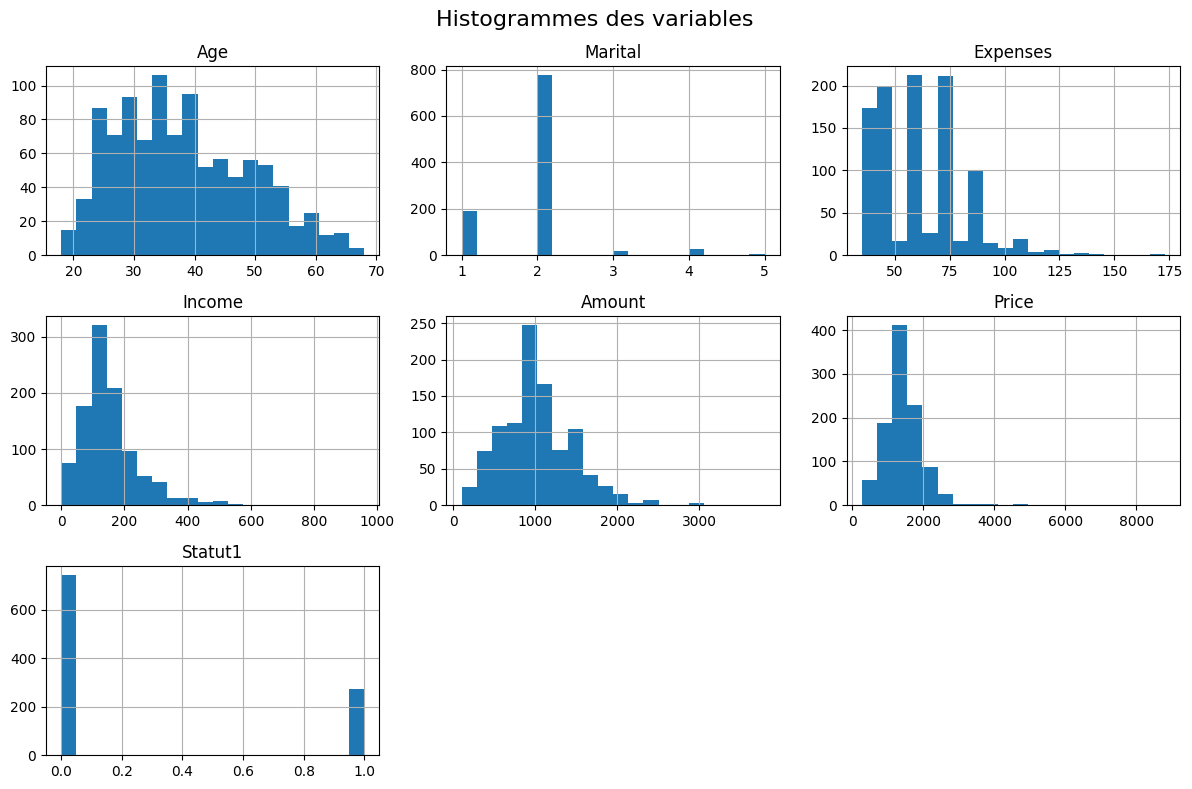

In [ ]:
# Distribution des variables numériques
df.hist(figsize=(12, 8), bins=20)
plt.suptitle("Histogrammes des variables", fontsize=16)
plt.tight_layout()
plt.show()

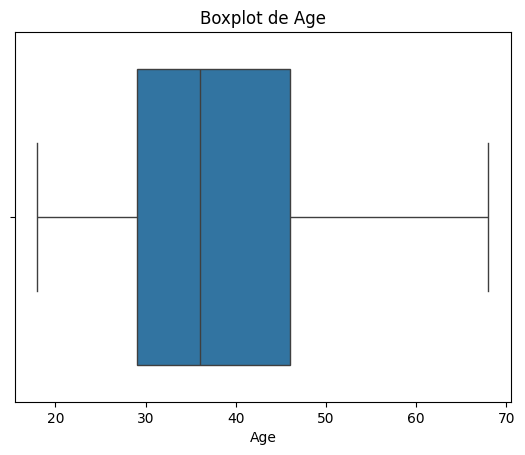

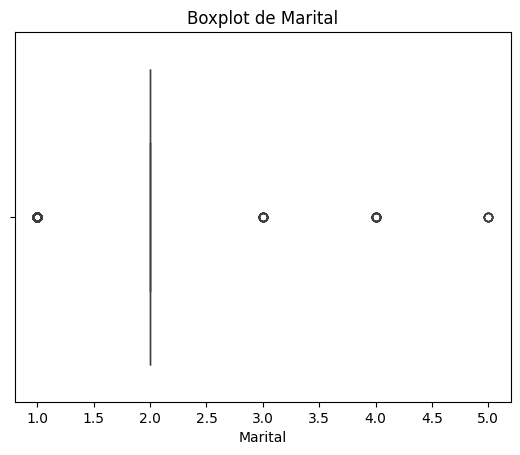

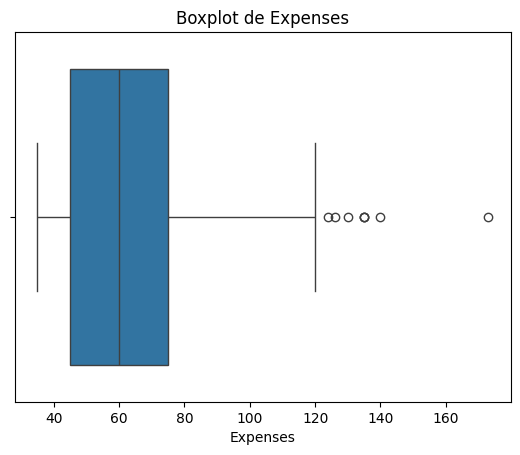

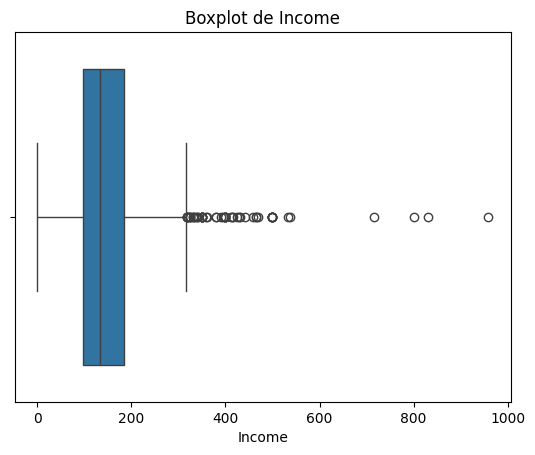

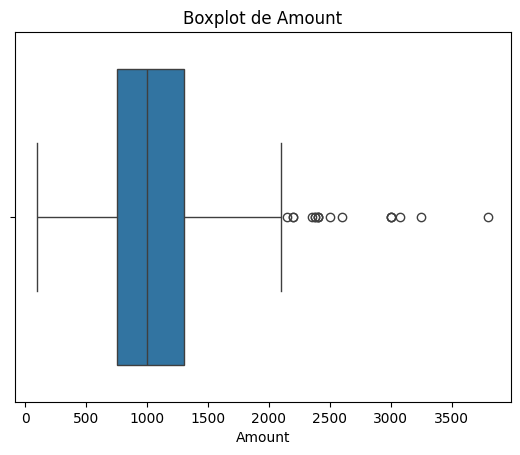

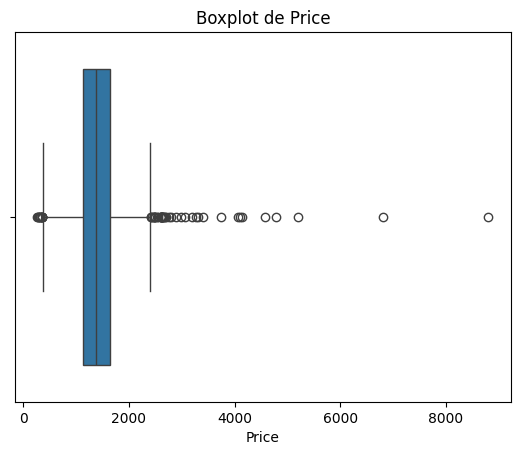

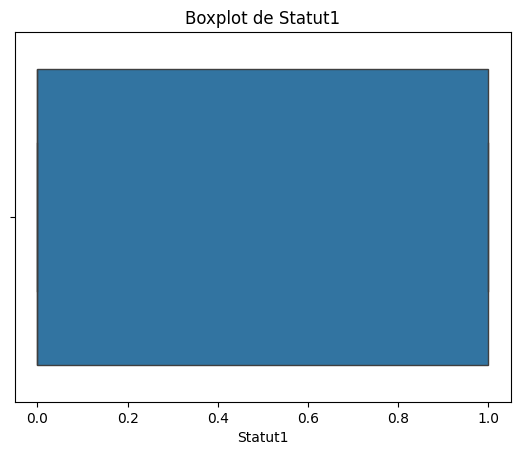

In [ ]:
# Boxplots
for col in df.select_dtypes(include='number').columns:
    plt.figure()
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot de {col}")
    plt.show()

👉   *  les variables Amounte ,Expenses,Price et Income
présentent des outliers .
- Les outliers peuvent introduire un biais dans les analyses et les prédictions, en particulier pour les modèles sensibles aux valeurs extrêmes (comme la régression).
- Une gestion efficace des outliers est nécessaire pour améliorer la robustesse des modèles.

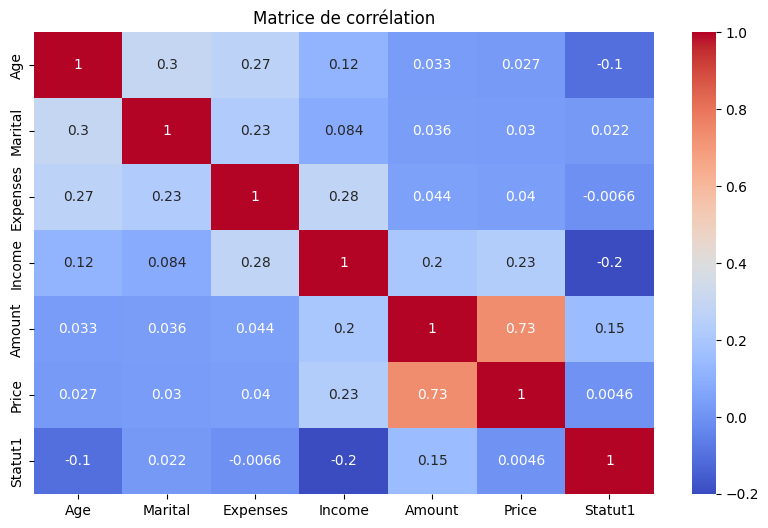

In [ ]:
# Corrélation
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Matrice de corrélation")
plt.show()

👉
- La forte corrélation entre `Amount` et `Price` peut poser des problèmes de multicolinéarité de 0,73.
- La multicolinéarité peut rendre les coefficients instables et nuire à l'interprétation des modèles, et pour ca on va suprimmer la variable Price par la suite .

In [ ]:
df['Amount'].describe()

,Amount
count,1015.000000
mean,1034.745813
std,452.833277
min,100.000000
25%,750.000000
50%,1000.000000
75%,1300.000000
max,3800.000000


In [ ]:
df['Statut1'].describe()
nsolva = df[df.Statut1 == 1]
solva = df[df.Statut1 == 0]

In [ ]:
nsolva.Amount.describe()

,Amount
count,273.000000
mean,1144.084249
std,500.549188
min,170.000000
25%,850.000000
50%,1100.000000
75%,1400.000000
max,3250.000000


In [ ]:
solva.Amount.describe()

,Amount
count,742.000000
mean,994.517520
std,427.330242
min,100.000000
25%,700.000000
50%,1000.000000
75%,1200.000000
max,3800.000000


👉   il y a un déséquilibre de classes dans la variable cible Statut1 :

- 742 cas pour Statut1 = 0
- 273 cas pour Statut1 = 1

---



# ✅ la regression Logistique :

- Entraînement d’un modèle de régression logistique simple avec une base prétraitée Sans valeurs aberrantes (outliers supprimés) et Équilibrée avec la méthode SMOTE pour corriger le déséquilibre des classes.

- Application de la validation croisée K-Fold pour :

- Évaluer la robustesse du modèle.

- Identifier les meilleurs hyperparamètres.



In [ ]:


# Séparation X / y
X = df.drop(columns='Statut1')
y = df['Statut1']

# Découpage train / test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Équilibrage des classes avec SMOTE :

In [ ]:

sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train_scaled, y_train)


In [ ]:

# Modèle
log_model = LogisticRegression(class_weight='balanced', random_state=42)
log_model.fit(X_resampled, y_resampled)

# Prédictions
y_pred_log = log_model.predict(X_test_scaled)

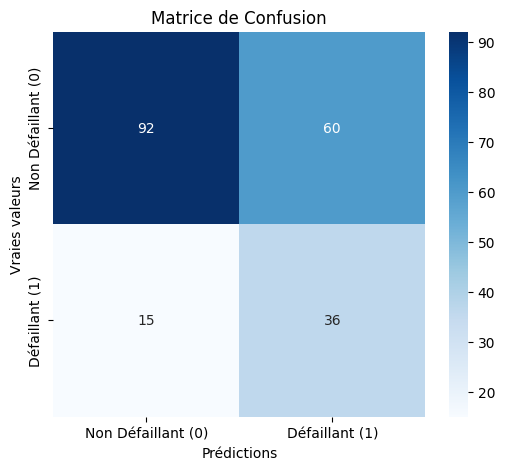

In [ ]:
# 1. Calcul de la matrice de confusion
cm = confusion_matrix(y_test, y_pred_log)

# 2. Affichage avec seaborn (graphique amélioré)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non Défaillant (0)", "Défaillant (1)"],
            yticklabels=["Non Défaillant (0)", "Défaillant (1)"])
plt.title("Matrice de Confusion")
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.show()

[[92 60]
 [15 36]]
              precision    recall  f1-score   support

         0.0       0.86      0.61      0.71       152
         1.0       0.38      0.71      0.49        51

    accuracy                           0.63       203
   macro avg       0.62      0.66      0.60       203
weighted avg       0.74      0.63      0.65       203

AUC : 0.7249742002063984


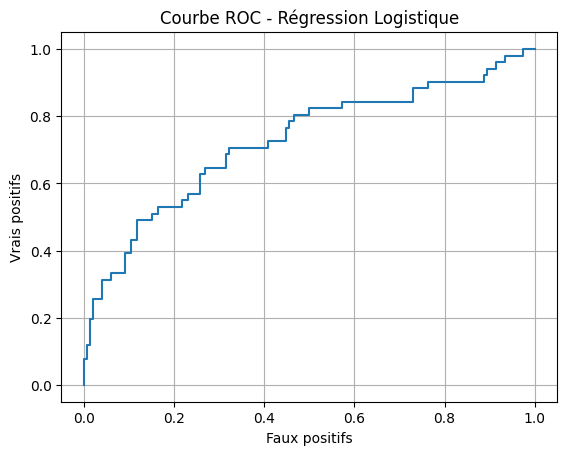

In [ ]:
# Évaluation
print(confusion_matrix(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))
print("AUC :", roc_auc_score(y_test, log_model.predict_proba(X_test_scaled)[:, 1]))

# ROC
fpr, tpr, _ = roc_curve(y_test, log_model.predict_proba(X_test_scaled)[:, 1])
plt.plot(fpr, tpr)
plt.xlabel("Faux positifs")
plt.ylabel("Vrais positifs")
plt.title("Courbe ROC - Régression Logistique")
plt.grid()
plt.show()

In [ ]:
print("Nombre total :", len(y_test))
print("Classe 0 dans test :", sum(y_test == 0))
print("Classe 1 dans test :", sum(y_test == 1))

Nombre total : 203
Classe 0 dans test : 152
Classe 1 dans test : 51


In [ ]:
print("Nombre total :", len( y_resampled))
print("Classe 0 dans train :", sum(y_resampled == 0))
print("Classe 1 dans train :", sum(y_resampled == 1))

Nombre total : 1180
Classe 0 dans train : 590
Classe 1 dans train : 590


In [ ]:
print("Nombre total :", len(y_train))
print("Classe 0 dans test :", sum(y_train == 0))
print("Classe 1 dans test :", sum(y_train == 1))

Nombre total : 812
Classe 0 dans test : 590
Classe 1 dans test : 222


#  # ✅ **la regression Logistique** sans ❌outliers(model final de regression logistique avec Recall=0,78 pour les cas NON solvables :

In [ ]:
def detect_outliers_iqr(data, variable):
    Q1 = data[variable].quantile(0.25)
    Q3 = data[variable].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return ((data[variable] < lower_bound) | (data[variable] > upper_bound))

# Exemple : détection des outliers pour Amount
df['outlier_amount'] = detect_outliers_iqr(df, 'Amount')

# Comptage des outliers par classe
df.groupby('Statut1')['outlier_amount'].sum()


,outlier_amount
Statut1,
0.0,8
1.0,9


In [ ]:
# Liste des variables à tester
variables = ['Amount', 'Expenses', 'Price', 'Income']

# Boucle pour créer une colonne d'outliers pour chaque variable
for var in variables:
    df[f'outlier_{var.lower()}'] = detect_outliers_iqr(df, var)

# Regrouper par Statut1 et compter les outliers
outlier_counts = df.groupby('Statut1')[[f'outlier_{v.lower()}' for v in variables]].sum()

# Afficher les résultats
print(outlier_counts)


         outlier_amount  outlier_expenses  outlier_price  outlier_income
Statut1                                                                 
0.0                   8                 6             35              47
1.0                   9                 2             18               8


In [ ]:
df_clean = df[
    ~(df['outlier_amount'] | df['outlier_expenses'] | df['outlier_price'] | df['outlier_income'])
]


In [ ]:


# Séparation X / y
Xc = df_clean.drop(columns='Statut1')
yc =df_clean['Statut1']

# Découpage train / test
Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc, test_size=0.2, random_state=42)

# Standardisation
scaler = StandardScaler()
Xc_train_scaled = scaler.fit_transform(Xc_train)
Xc_test_scaled = scaler.transform(Xc_test)

In [ ]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
Xc_resampled, yc_resampled = sm.fit_resample(Xc_train_scaled, yc_train)


# 👉verification des outliers :

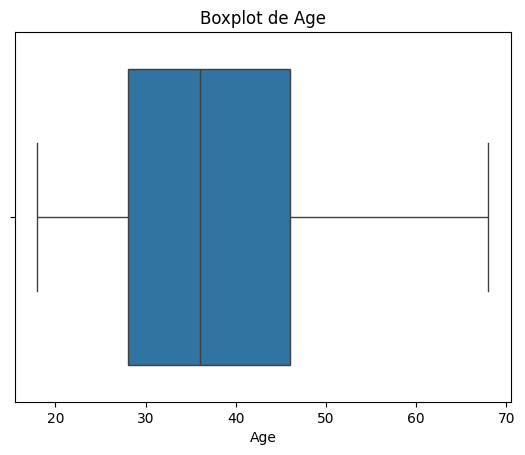

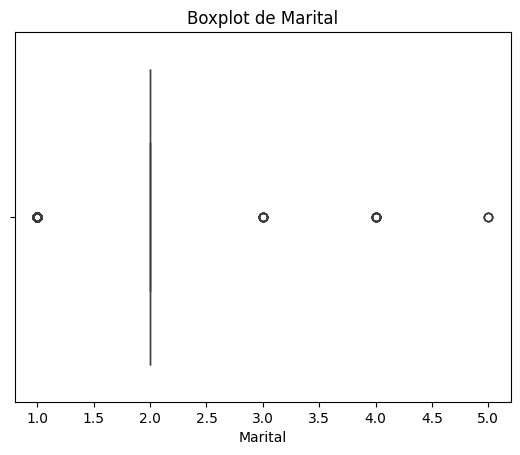

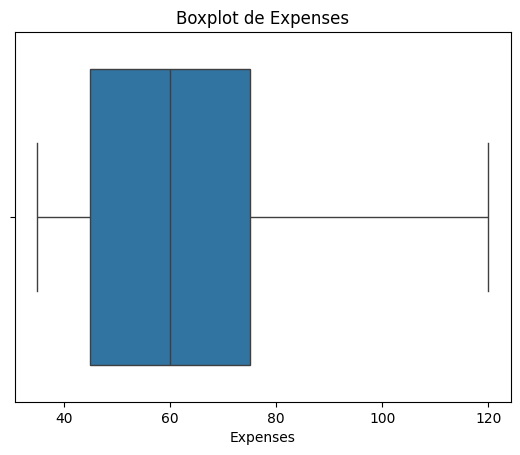

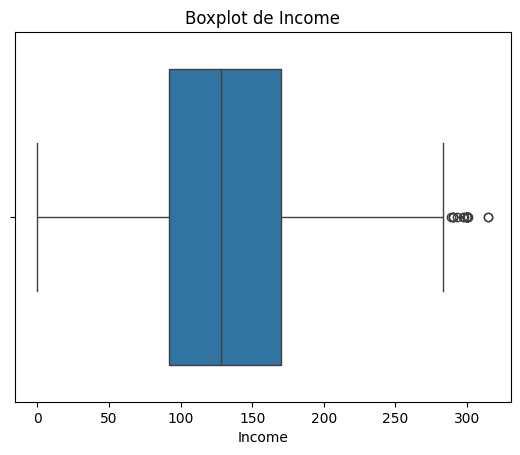

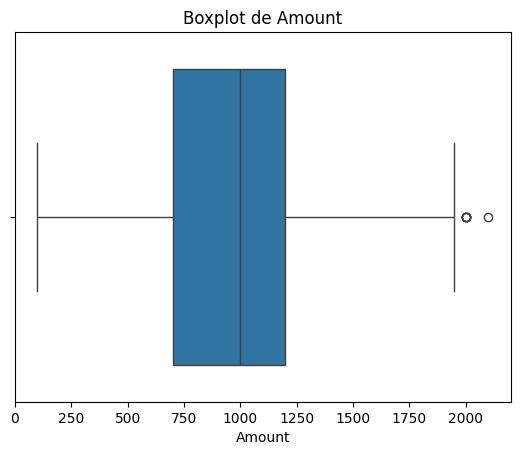

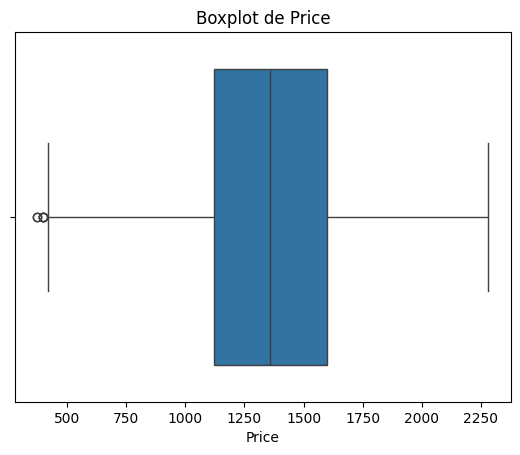

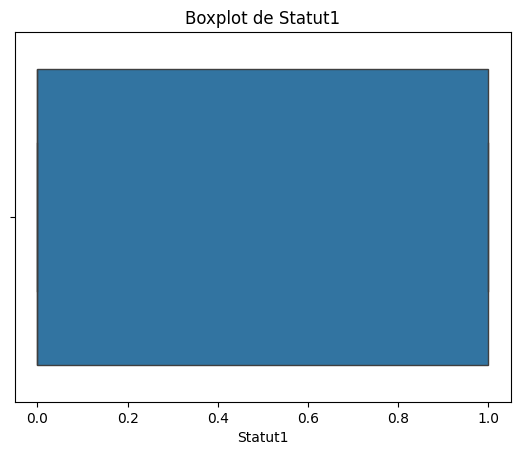

In [ ]:
df_clean.describe()
# Boxplots
for col in df_clean.select_dtypes(include='number').columns:
    plt.figure()
    sns.boxplot(x=df_clean[col])
    plt.title(f"Boxplot de {col}")
    plt.show()

In [ ]:


# Modèle
log_modelc= LogisticRegression(class_weight='balanced', random_state=42)
log_modelc.fit(Xc_resampled, yc_resampled)

# Prédictions
yc_pred_log = log_modelc.predict(Xc_test_scaled)


📊 Rapport de classification :
               precision    recall  f1-score   support

         0.0       0.88      0.63      0.73       133
         1.0       0.43      0.76      0.55        49

    accuracy                           0.66       182
   macro avg       0.65      0.69      0.64       182
weighted avg       0.76      0.66      0.68       182



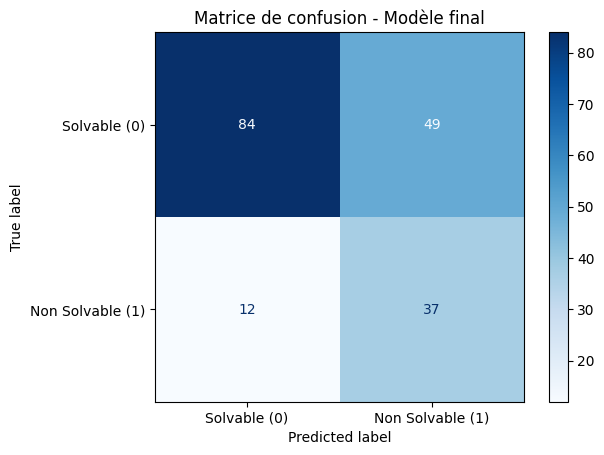

In [ ]:

# 4️⃣ Évaluation
print("📊 Rapport de classification :\n", classification_report(yc_test, yc_pred_log))
# Attention : pour roc_auc_score, on préfère les probabilités pour la classe 1print("📌 AUC ROC :", roc_auc_score(yc_test, y_pred_proba))

# 5️⃣ Matrice de confusion
cm = confusion_matrix(yc_test, yc_pred_log)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Solvable (0)", "Non Solvable (1)"])
disp.plot(cmap='Blues')
plt.title("Matrice de confusion - Modèle final")
plt.grid(False)
plt.show()


#✅ utilisation de la validation croisée k-fold pour évaluer les performances des modèle de régression logistique :






In [ ]:

# 3. Pipeline avec standardisation
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(random_state=42, class_weight='balanced'))  # Ajout du poids équilibré
])

# 4. Grille d'hyperparamètres optimisée
param_grid = {
    'model__C': np.logspace(-3, 2, 6),  # [0.001, 0.01, ..., 100]
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['liblinear'],
    'model__max_iter': [500]
}

# 5. Recherche du meilleur modèle
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=2
)

print("Optimisation en cours...")
grid_search.fit(Xc_train_scaled, yc_train)

# 6. Meilleur modèle
best_model = grid_search.best_estimator_
print("\n🔍 Meilleurs paramètres:", grid_search.best_params_)
print("🏆 Meilleur score F1 (validation):", grid_search.best_score_)





Optimisation en cours...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

🔍 Meilleurs paramètres: {'model__C': np.float64(10.0), 'model__max_iter': 500, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
🏆 Meilleur score F1 (validation): 0.5172110168089108


In [ ]:

y_proba = best_model.predict_proba(Xc_test_scaled)[:, 1]  # Probabilités classe positive
precisions, recalls, thresholds = precision_recall_curve(yc_test, y_proba)

# Calcul du F1-score pour chaque seuil
f1_scores = (2 * precisions * recalls) / (precisions + recalls + 1e-8)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"\n🎯 Seuil optimal (max F1): {optimal_threshold:.4f}")



🎯 Seuil optimal (max F1): 0.5201


In [ ]:
# 6. Évaluation avec seuil optimisé
y_pred_optimized = (y_proba >= optimal_threshold).astype(int)

print("\n📊 Rapport de classification optimisé:")
print(classification_report(yc_test, y_pred_optimized,
                          target_names=['Solvable', 'Non solvable']))

# 7. Visualisation
plt.figure(figsize=(15, 5))


📊 Rapport de classification optimisé:
              precision    recall  f1-score   support

    Solvable       0.88      0.66      0.76       133
Non solvable       0.45      0.76      0.56        49

    accuracy                           0.69       182
   macro avg       0.67      0.71      0.66       182
weighted avg       0.76      0.69      0.70       182



<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

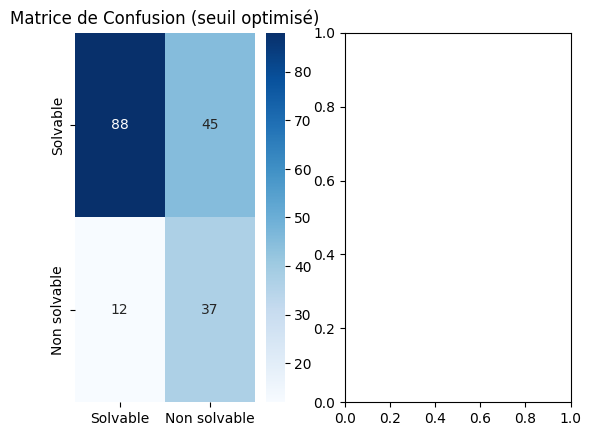

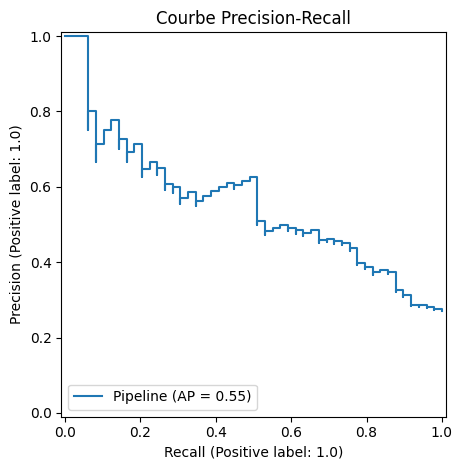

In [ ]:
# Matrice de confusion
plt.subplot(1, 2, 1)
cm = confusion_matrix(yc_test, y_pred_optimized)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Solvable', 'Non solvable'],
            yticklabels=['Solvable', 'Non solvable'])
plt.title('Matrice de Confusion (seuil optimisé)')

# Courbe Precision-Recall
plt.subplot(1, 2, 2)
PrecisionRecallDisplay.from_estimator(best_model, Xc_test_scaled, yc_test)
plt.title('Courbe Precision-Recall')
plt.tight_layout()
plt.show()

# ✅le téléchargement du le meilleur modèle de régression logistique :

In [ ]:
# Correction du bloc de sauvegarde du modèle
model_data = {
    'model': best_model,
    'threshold': optimal_threshold,
    'features': list(range(X_resampled.shape[1])) if not hasattr(X_resampled, 'columns') else X_resampled.columns.tolist()
}
joblib.dump(log_modelc, 'logic-model.pkl')
print("\n💾 Modèle sauvegardé sous 'REGLOG.pkl'")



💾 Modèle sauvegardé sous 'REGLOG.pkl'


In [ ]:
files.download('logic-model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 🔹KNN::


Modèle KNN entraîné avec 7 voisins

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.78      0.90      0.84       152
         1.0       0.46      0.25      0.33        51

    accuracy                           0.74       203
   macro avg       0.62      0.58      0.58       203
weighted avg       0.70      0.74      0.71       203


Matrice de confusion :


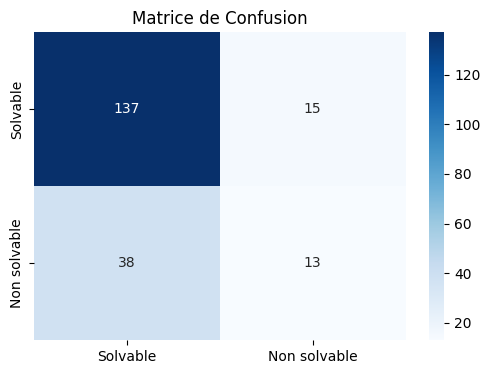

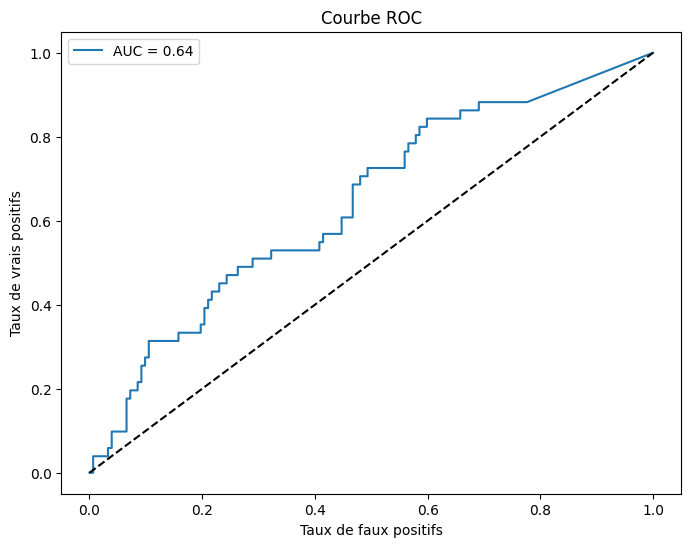

In [ ]:


class ModeleKNN:
    def __init__(self, k=5, weights='uniform'):
        """Initialise le modèle KNN

        Args:
            k (int): Nombre de voisins (défaut: 5)
            weights (str): 'uniform' ou 'distance' (défaut: 'uniform')
        """
        self.model = KNeighborsClassifier(n_neighbors=k, weights=weights)

    def entrainer(self, X_train, y_train):
        """Entraîne le modèle sur les données fournies"""
        self.model.fit(X_train, y_train)
        print(f"Modèle KNN entraîné avec {self.model.n_neighbors} voisins")

    def evaluer(self, X_test, y_test):
        """Évalue le modèle et affiche les métriques"""
        # Prédictions
        y_pred = self.model.predict(X_test)
        y_proba = self.model.predict_proba(X_test)[:, 1]

        # Métriques
        print("\n" + "="*50)
        print("Rapport de classification :")
        print(classification_report(y_test, y_pred))

        print("\nMatrice de confusion :")
        plt.figure(figsize=(6, 4))
        sns.heatmap(confusion_matrix(y_test, y_pred),
                    annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Solvable', 'Non solvable'],
                    yticklabels=['Solvable', 'Non solvable'])
        plt.title('Matrice de Confusion')
        plt.show()

        # Courbe ROC
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.2f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('Taux de faux positifs')
        plt.ylabel('Taux de vrais positifs')
        plt.title('Courbe ROC')
        plt.legend()
        plt.show()

        print("\n" + "="*50)

# Exemple d'utilisation avec vos données prétraitées :
if __name__ == "__main__":
    # Supposons que vous avez déjà :
    # X_train, X_test, y_train, y_test = ... (données prétraitées)

    # 1. Initialisation
    knn = ModeleKNN(k=7, weights='distance')  # Testez avec différents k

    # 2. Entraînement
    knn.entrainer(X_train,y_train)

    # 3. Évaluation
    knn.evaluer(X_test, y_test)

##✅  Evaluation de KNN avec K-fold Cross Validation :
#choix du meilleur model :

# ✅ le meilleur modèle KNN après la sélection :

In [ ]:
joblib.dump(knn_model, 'KNN.pkl')
print("\n💾 Modèle sauvegardé sous 'KNN.pkl.pkl'")


💾 Modèle sauvegardé sous 'KNN.pkl.pkl'


In [ ]:
joblib.dump(log_model, 'log_model.pkl')
print("\n💾 Modèle sauvegardé sous 'log_model.pkl'")
files.download('log_model.pkl')



💾 Modèle sauvegardé sous 'log_model.pkl'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:


files.download('REGLOG.pkl')
files.download('KNN.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:




joblib.dump(model, 'log_model.pkl')


['log_model.pkl']

In [ ]:

# Découpage train / test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
scaler_path = 'scaler.pkl'  # Will save in 'models' folder
joblib.dump(scaler, scaler_path)

# 5. Test loading the scaler
loaded_scaler = joblib.load(scaler_path)
print("\n✔ Scaler test load successful!" if hasattr(loaded_scaler, 'mean_')
      else "❌ Problem with saved scaler")
files.download('scaler.pkl')




✔ Scaler test load successful!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import joblib

# Sauvegarde du modèle entraîné
joblib.dump(knn_model, "ModeleKNNOptimise.pkl")
files.download('ModeleKNNOptimise.pkl')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Optimisation avancée en cours...
Fitting 5 folds for each of 3360 candidates, totalling 16800 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
2100 fits failed out of a total of 16800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
700 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 526, in fit
    self._final_estimator.fit(Xt, 


Top 5 des meilleures combinaisons:
                                                 params  mean_test_score
139   {'kneighborsclassifier__algorithm': 'auto', 'k...         0.489239
1819  {'kneighborsclassifier__algorithm': 'kd_tree',...         0.489239
979   {'kneighborsclassifier__algorithm': 'ball_tree...         0.489239
2659  {'kneighborsclassifier__algorithm': 'brute', '...         0.489239
977   {'kneighborsclassifier__algorithm': 'ball_tree...         0.488425

Meilleurs paramètres trouvés:
{'kneighborsclassifier__algorithm': 'auto', 'kneighborsclassifier__metric': 'minkowski', 'kneighborsclassifier__n_neighbors': 29, 'kneighborsclassifier__p': 3, 'kneighborsclassifier__weights': 'distance'}

Performance avec seuil standard (0.5):
              precision    recall  f1-score   support

    Solvable       0.84      0.72      0.78       152
Non solvable       0.42      0.61      0.50        51

    accuracy                           0.69       203
   macro avg       0.63      0.6

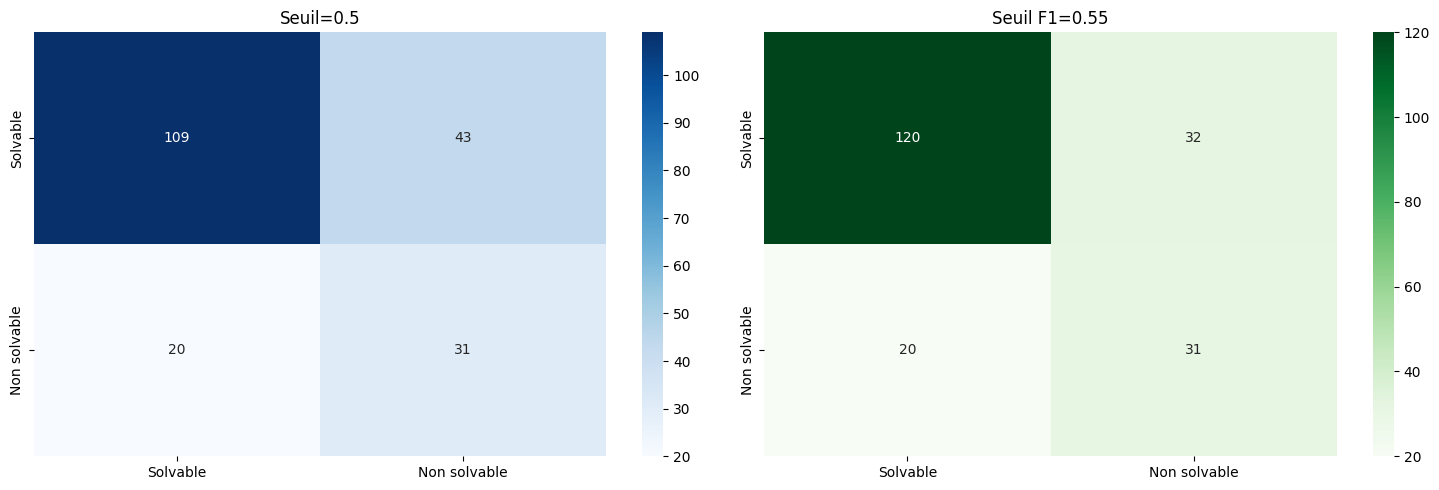

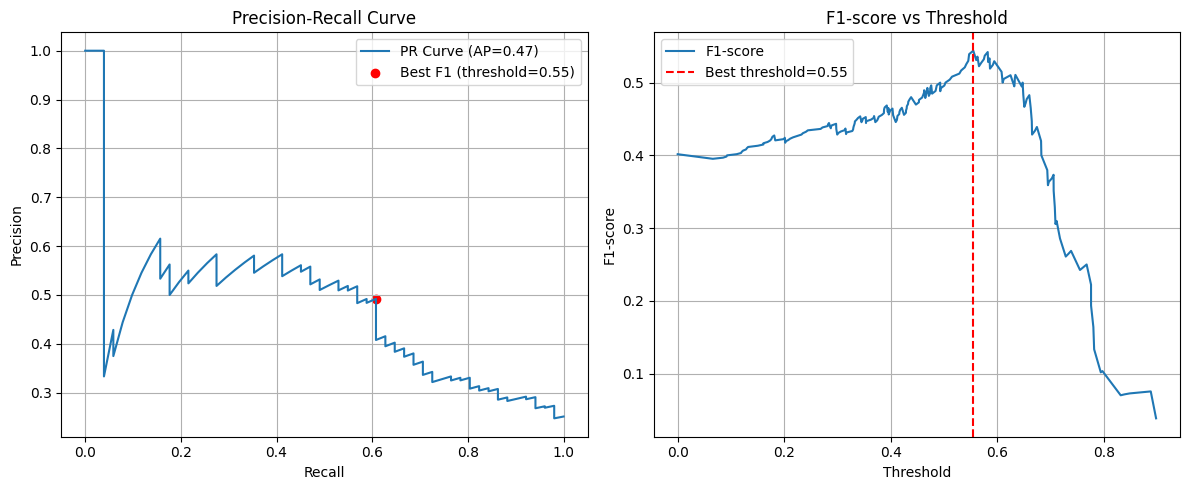


Modèle sauvegardé sous 'best_knn_optimized.joblib'


In [ ]:
from sklearn.impute import SimpleImputer
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import average_precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (classification_report, confusion_matrix,
                           roc_auc_score, precision_recall_curve)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pandas as pd
from imblearn.over_sampling import SMOTE

def optimize_knn(X_train, y_train):
    """Optimisation du modèle KNN avec distances avancées"""

    # Pipeline complet avec gestion des déséquilibres
    pipeline = make_imb_pipeline(
        SimpleImputer(strategy='median'),
        RobustScaler(),
        SMOTE(random_state=42),
        KNeighborsClassifier()
    )

    # Grille de paramètres valide
    param_grid = {
        'kneighborsclassifier__n_neighbors': range(3, 30, 2),  # Plage raisonnable
        'kneighborsclassifier__weights': ['uniform', 'distance'],  # Seules options valides
        'kneighborsclassifier__p': [1, 1.5, 2, 2.5, 3],  # Distances Minkowski
        'kneighborsclassifier__metric': [
            'minkowski',
            'euclidean',
            'manhattan',
            'chebyshev',
            'cosine',
            'canberra'
        ],
        'kneighborsclassifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    }

    # Optimisation
    grid = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,
        scoring='average_precision',
        n_jobs=-1,
        verbose=2
    )

    print("Optimisation avancée en cours...")
    grid.fit(X_train, y_train)

    # Affichage des meilleures combinaisons
    print("\nTop 5 des meilleures combinaisons:")
    results = pd.DataFrame(grid.cv_results_)
    top_results = results.sort_values(by='rank_test_score').head(5)
    print(top_results[['params', 'mean_test_score']])

    return grid.best_estimator_, grid.best_params_

def evaluate_model(model, X_test, y_test):
    """Évaluation avancée du modèle"""

    # Prédictions et probabilités
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Optimisation du seuil
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    y_pred_optim = (y_proba >= best_threshold).astype(int)

    # Métriques
    print("\n" + "="*60)
    print("Performance avec seuil standard (0.5):")
    print(classification_report(y_test, y_pred,
                              target_names=['Solvable', 'Non solvable']))

    print(f"\nPerformance avec seuil optimisé F1 ({best_threshold:.2f}):")
    print(classification_report(y_test, y_pred_optim,
                              target_names=['Solvable', 'Non solvable']))

    print("\nMetrics Summary:")
    print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.4f}")
    print(f"Average Precision: {average_precision_score(y_test, y_proba):.4f}")
    print(f"Best F1-score: {f1_scores[best_idx]:.4f} à threshold={best_threshold:.2f}")

    # Visualisations
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Matrices de confusion
    for ax, pred, title, cmap in zip(
        axes,
        [y_pred, y_pred_optim],
        ["Seuil=0.5", f"Seuil F1={best_threshold:.2f}"],
        ['Blues', 'Greens']
    ):
        sns.heatmap(confusion_matrix(y_test, pred),
                   annot=True, fmt='d', cmap=cmap, ax=ax,
                   xticklabels=['Solvable', 'Non solvable'],
                   yticklabels=['Solvable', 'Non solvable'])
        ax.set_title(title)

    plt.tight_layout()
    plt.show()

    # Courbes
    plt.figure(figsize=(12, 5))

    # Courbe Precision-Recall
    plt.subplot(1, 2, 1)
    plt.plot(recall, precision, label=f'PR Curve (AP={average_precision_score(y_test, y_proba):.2f})')
    plt.scatter(recall[best_idx], precision[best_idx], c='red',
                label=f'Best F1 (threshold={best_threshold:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid()

    # Courbe F1
    plt.subplot(1, 2, 2)
    plt.plot(thresholds, f1_scores[:-1], label='F1-score')
    plt.axvline(best_threshold, color='red', linestyle='--',
                label=f'Best threshold={best_threshold:.2f}')
    plt.xlabel('Threshold')
    plt.ylabel('F1-score')
    plt.title('F1-score vs Threshold')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

def main():
    """Workflow complet"""
    # Chargement des données
    # [Votre code existant pour charger les données]

    # Optimisation
    best_knn, best_params = optimize_knn(X_train, y_train)
    print("\nMeilleurs paramètres trouvés:")
    print(best_params)

    # Évaluation
    evaluate_model(best_knn, X_test, y_test)

    # Sauvegarde
    save_data = {
        'model': best_knn,
        'best_params': best_params,
        'timestamp': pd.Timestamp.now()
    }
    joblib.dump(save_data, 'best_knn_optimized.joblib')
    print("\nModèle sauvegardé sous 'best_knn_optimized.joblib'")

if __name__ == "__main__":
    main()

In [ ]:
joblib.dump(knn,'Knn.pkl')
files.download('Knn.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>